dataset(correlation + PCA + mrmr) -> 5 fold cross validation (outer) -> training dataset & validation dataset

training dataset -> 5 fold cross validation (inner) -> best model settings for all 3 models due to optimized AUC -> train on the training dataset -> 3*5 scoring metrics each with 5 evaluations

validation dataset -> validate on the validation dataset -> 3*5 performance scoring metricseach with 5 evaluations

In [15]:
from datetime import datetime
import pandas as pd
from scipy.stats import loguniform 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd
from calcDrop_v2 import corrX_new
import numpy as np
from sklearn.inspection import permutation_importance as pfi
from mrmr import mrmr_classif
import pickle
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GroupShuffleSplit, cross_validate
from split_new import RepeatedStratifiedGroupKFold
# from sklearn.model_selection import RepeatedStratifiedGroupKFold
from imblearn.metrics import specificity_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [16]:
df = pd.read_excel(r'D:\code备份\7.29\Hesheng Gong - code\feature_map_729.xlsx')
pnam = df['Patient name ' ]
X = df.drop(['Slice no. ', 'Label', 'Patient name '], axis=1)
y = df['Label']

In [17]:
to_drop = corrX_new(X, y, cut = 0.9)
X = X.drop(to_drop, axis=1)
df = df.drop(to_drop, axis=1)
print("Number of features left after dropping highly correlated features: ", np.shape(X)[1])

Number of features left after dropping highly correlated features:  77


In [18]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pca = PCA(.95).fit(X_scaled)
print("Number of components left after PCA: ", pca.n_components_)
features_PCA = pca.transform(X_scaled)

Number of components left after PCA:  18


In [19]:
# X = df.drop(['Slice no. ', 'Label', 'Patient name '], axis =1)
selected_features = mrmr_classif(X=X, y=y, K=pca.n_components_)
X = X[selected_features]
featNames = X.columns

100%|██████████| 18/18 [00:00<00:00, 38.92it/s]


In [20]:
for name in featNames:
    print(name)

# 将PCA成分名称保存到文本文件
with open('featNames.txt', 'w') as file:
    for name in featNames:
        file.write(name + '\n')

print("PCA feature names have been saved to 'featNames.txt'")

DCEpeak.Global.Kurtosis
T2.Global.Variance
ADC.GLSZM.ZP
MRDI.kep
ADC.grayscale_raw
DCEwashin.GLCM.AutoCorrelation
DCEpeak.GLSZM.LZLGE
ADC.Global.Variance
DCEpeak.GLSZM.HGZE
DCEwashin.GLSZM.SZLGE
DCEwashin.GLSZM.GLN
T2.GLRLM.GLN
DCEwashin.Global.Skewness
T2.GLCM.AutoCorrelation
DCEwashin.Global.Kurtosis
DCEwashin.GLCM.Variance
T2.GLSZM.SZE
DCEpeak.GLRLM.LGRE
PCA feature names have been saved to 'featNames.txt'


In [21]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
print(dt_string)

08_08_2024__00_06_16


In [22]:
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, balanced_accuracy_score, recall_score

models = ["kNN","SVM","LR"]

cv_outer = RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=1, random_state=42)

specificity = make_scorer(recall_score, pos_label = 0)

multi_scorings = {"AUC": "roc_auc", "ACC": "accuracy", "bACC" :'balanced_accuracy', 
                  "SENS": "recall", "SPEC": specificity}

scoring_metrics=['AUC','bACC', 'ACC', 'SENS', 'SPEC']

In [23]:
plot_data = {model_name: {'n_features': [], 'mean_auc': [], 'std_auc': []} for model_name in models}

In [24]:
# # Initialize variables
# final_results = []
# training_metrics = []
# test_metrics = []
# training_metrics_all = []
# test_metrics_all = []
# pfi_all = []

# groups = pnam.values

# test_save_x = []
# test_save_y = []
# test_save_pnam = []
# test_save_index = []
# pfis = {}


# # 5-fold cross-validation
# for train_idx, test_idx in cv_outer.split(X, y, groups):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     pnam_train, pnam_test = pnam[train_idx], pnam[test_idx]
#     test_save_x = [test_save_x, X_test]
#     test_save_y = [test_save_y, y_test]
#     test_save_pnam = [test_save_pnam, pnam_test]
#     test_save_index = [test_save_index, test_idx]

#     model_results = {}
#     aggregated_importance = {model_name: np.zeros(X.shape[1]) for model_name in models}

#     # for scoring_metric in scoring_metrics:
#     for model_name in models:
#         # pfis = []
    
#         final_dict, final_dict_avg = {}, {}
#         result_outer = list()
#         features_number, grid_score, grid_parms = [], [], []
#         n_features_list, result_outer_mean, result_outer_std = [], [], []
#         df_res_cv = pd.DataFrame()
#         rankings, selecfeat_names = [], []
#         best_models = []
#         best_aucs = []
#         n_features_list = []
#         mean_scores = []
#         std_scores = []

#         if model_name == "LR":
#             print("Evaluating for {}".format(model_name))
#             model = LogisticRegression(class_weight='balanced')
#             space = {
#                 'solver': ['liblinear'],
#                 'penalty': ['l1', 'l2'],
#                 'C': loguniform(1e-5, 10)
#             }
#             n_iter = 50

#         elif model_name == "kNN":
#             print("Evaluating for {}".format(model_name))
#             model = KNeighborsClassifier()
#             space = {
#                 'n_neighbors': list(range(3, len(X_train))),
#                 'weights': ['uniform', 'distance'],
#                 'metric': ['minkowski']
#             }
#             n_iter = 20

#         elif model_name == "SVM":
#             print("Evaluating for {}".format(model_name))
#             model = SVC(class_weight='balanced')
#             space = {
#                 'kernel': ['poly', 'rbf', 'sigmoid'],
#                 'C': loguniform(1e-4, 10),
#                 'gamma': loguniform(1e-4, 10)
#             }
#             n_iter = 100

#         # for n_features in range(5, np.shape(X)[1] + 1):
#         for n_features in range(5, np.shape(X)[1] + 1):
#             print("Using %s features" % (n_features))
#             n_features_list.append(n_features)

#             scaler = StandardScaler()
#             Xscaled = scaler.fit_transform(X_train, y_train)
#             selector = RFE(LogisticRegression(class_weight='balanced', C=0.034, penalty='l2', solver='liblinear'), n_features_to_select=n_features)

#             selector.fit(Xscaled, y_train)
#             X_sub = X_train.iloc[:, selector.support_]
#             # selecfeat_names.append(X.columns[selector.support_]) # feature list as selected ones
#             selecfeat_names.append(np.where(selector.support_)[0])
#             rankings.append(selector.ranking_) # ranking for features on their importance

#             cv_inner = list(RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=1, random_state=42).split(X_sub, y_train, pnam_train))
#             X_sub = scaler.fit_transform(X_sub, y_train)

#             random_search = RandomizedSearchCV(model, space, n_iter=20, scoring=multi_scorings['AUC'], n_jobs=-1, cv=cv_inner, error_score=0, refit=True)
#             result_inner = random_search.fit(X_sub, y_train) # 5 folds each including index for training and validation
#             print(result_inner)

#             cv_results = result_inner.cv_results_
#             mean_score = cv_results['mean_test_score'].mean() #20 -MEAN-> 1
#             std_score = cv_results['mean_test_score'].std() #20 -STD-> 1
#             print(mean_score)
#             print(std_score)
#             mean_scores.append(mean_score) # 1*14
#             std_scores.append(std_score) # 1*14
#             print(mean_scores)
#             print(std_scores)

#             best_auc = result_inner.best_score_ # 1
#             print(best_auc)
#             best_aucs.append(best_auc) # 1*14
#             best_model = result_inner.best_estimator_ # 1
#             print(best_model)
#             best_models.append(best_model) # 1*14
#             print(best_models)

#         # Update plot_data with mean and std of AUCs for each feature set size
#         plot_data[model_name]['n_features'] = n_features_list
#         plot_data[model_name]['mean_auc'] = mean_scores
#         plot_data[model_name]['std_auc'] = std_scores

#         print(plot_data) # 3*1*14

#         # 找出最高 AUC 值的索引
#         max_auc_index = best_aucs.index(max(best_aucs))

#         # 获取对应的最佳模型和 n_features 值
#         max_auc = best_aucs[max_auc_index]
#         best_model_for_max_auc = best_models[max_auc_index]
#         n_features_for_max_auc = n_features_list[max_auc_index]
#         best_features = selecfeat_names[max_auc_index] # INDEX FOR FEATURE NAMES

#         model_results[model_name] = {
#         "max_auc": max_auc,
#         "best_model": best_model_for_max_auc,
#         "n_features": n_features_for_max_auc,
#         "feature_list": best_features
#         }
        
#          # Train best model on the entire training set
#         X_train_sub = X_train.iloc[:, best_features]
#         best_model_for_max_auc.fit(X_train_sub, y_train)

#         # # Evaluate model on training set using all metrics
#         # y_train_pred = best_model_for_max_auc.predict(X_train.iloc[:, selector.support_])
#         # # y_train_proba = best_model_for_max_auc.predict_proba(X_train.iloc[:, selector.support_])[:, 1]
#         # # Use predict_proba only if available (specifically for SVM with probability=True)
#         # if hasattr(best_model_for_max_auc, "predict_proba"):
#         #     y_train_proba = best_model_for_max_auc.predict_proba(X_train.iloc[:, selector.support_])[:, 1]
#         # else:
#         #     # Fall back to decision_function or some form of scoring if proba is not available
#         #     y_train_proba = best_model_for_max_auc.decision_function(X_train.iloc[:, selector.support_])

#         # results = {
#         #     "AUC": roc_auc_score(y_train, y_train_proba),
#         #     "ACC": accuracy_score(y_train, y_train_pred),
#         #     "bACC": balanced_accuracy_score(y_train, y_train_pred),
#         #     "SENS": recall_score(y_train, y_train_pred, pos_label=1),
#         #     "SPEC": specificity_score(y_train, y_train_pred)
#         # }

#         # # training_metrics.append(results)

#         # # Print results
#         # print(f"Training results for {model_name}: {results}")

#         # Validate on the test set
#         X_test_sub = X_test.iloc[:, best_features]
#         y_test_pred = best_model_for_max_auc.predict(X_test_sub)
        
#         # if hasattr(best_model_for_max_auc, "predict_proba"):
#         #     y_test_proba = best_model_for_max_auc.predict_proba(X_test_sub)[:, 1]
#         # else:
#         #     y_test_proba = best_model_for_max_auc.decision_function(X_test_sub)

#         test_results = {
#             "AUC": roc_auc_score(y_test, y_test_pred),
#             "ACC": accuracy_score(y_test, y_test_pred),
#             "bACC": balanced_accuracy_score(y_test, y_test_pred),
#             "SENS": recall_score(y_test, y_test_pred, pos_label=1),
#             "SPEC": specificity_score(y_test, y_test_pred)
#         }

#         print(f"Test results for {model_name}: {test_results}")

#         test_metrics.append(test_results)

#         pfi_per_metrics = {}

#         # for mtr in scoring_metrics:
#             # Compute Permutation Feature Importance (PFI)
#         pfi_results = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring='roc_auc',  n_repeats=10, random_state=42)
#         # pfi_per_metrics = pfi_results

#         pfis[model_name] = pfi_results
#         #     feature_importance = pfi_results.importances_mean.flatten()

#         #     # # Normalize importance
#         #     # min_importance = feature_importance.min()
#         #     # feature_importance = feature_importance - min_importance
#         #     # if feature_importance.max() > 0:
#         #     #     feature_importance /= feature_importance.max()

#         #     # Aggregate importance
#         #     full_feature_importance = np.zeros(X.shape[1])
#         #     full_feature_importance[selector.support_] = feature_importance
#         #     aggregated_importance[model_name] += full_feature_importance

#     final_results.append(model_results)
#     # training_metrics.append(results)
#     test_metrics_all.append(test_metrics)
#     pfi_all.append(pfis)

# # training_metrics_all.append(training_metrics)
# # test_metrics_all.append(test_metrics)


In [25]:
# Initialize variables
final_results = []
training_metrics = []
test_metrics = []
training_metrics_all = []
test_metrics_all = []

pfi_auc_all = []
pfi_acc_all = []
pfi_bacc_all = []
pfi_sens_all = []
pfi_spec_all = []

groups = pnam.values

test_save_x = []
test_save_y = []
test_save_pnam = []
test_save_index = []
pfis_auc = {}
pfis_acc = {}
pfis_bacc = {}
pfis_sens = {}
pfis_spec = {}


# 5-fold cross-validation
for train_idx, test_idx in cv_outer.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    pnam_train, pnam_test = pnam[train_idx], pnam[test_idx]
    test_save_x = [test_save_x, X_test]
    test_save_y = [test_save_y, y_test]
    test_save_pnam = [test_save_pnam, pnam_test]
    test_save_index = [test_save_index, test_idx]

    model_results = {}
    aggregated_importance = {model_name: np.zeros(X.shape[1]) for model_name in models}

    # for scoring_metric in scoring_metrics:
    for model_name in models:
        # pfis = []
    
        final_dict, final_dict_avg = {}, {}
        result_outer = list()
        features_number, grid_score, grid_parms = [], [], []
        n_features_list, result_outer_mean, result_outer_std = [], [], []
        df_res_cv = pd.DataFrame()
        rankings, selecfeat_names = [], []
        best_models = []
        best_aucs = []
        n_features_list = []
        mean_scores = []
        std_scores = []

        if model_name == "LR":
            print("Evaluating for {}".format(model_name))
            model = LogisticRegression(class_weight='balanced')
            space = {
                'solver': ['liblinear'],
                'penalty': ['l1', 'l2'],
                'C': loguniform(1e-5, 10)
            }
            n_iter = 50

        elif model_name == "kNN":
            print("Evaluating for {}".format(model_name))
            model = KNeighborsClassifier()
            space = {
                'n_neighbors': list(range(3, len(X_train))),
                'weights': ['uniform', 'distance'],
                'metric': ['minkowski']
            }
            n_iter = 20

        elif model_name == "SVM":
            print("Evaluating for {}".format(model_name))
            model = SVC(class_weight='balanced')
            space = {
                'kernel': ['poly', 'rbf', 'sigmoid'],
                'C': loguniform(1e-4, 10),
                'gamma': loguniform(1e-4, 10)
            }
            n_iter = 100

        # for n_features in range(5, np.shape(X)[1] + 1):
        for n_features in range(5, np.shape(X)[1] + 1):
            print("Using %s features" % (n_features))
            n_features_list.append(n_features)

            scaler = StandardScaler()
            Xscaled = scaler.fit_transform(X_train, y_train)
            selector = RFE(LogisticRegression(class_weight='balanced', C=0.034, penalty='l2', solver='liblinear'), n_features_to_select=n_features)

            selector.fit(Xscaled, y_train)
            X_sub = X_train.iloc[:, selector.support_]
            # selecfeat_names.append(X.columns[selector.support_]) # feature list as selected ones
            selecfeat_names.append(np.where(selector.support_)[0])
            rankings.append(selector.ranking_) # ranking for features on their importance

            cv_inner = list(RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=1, random_state=42).split(X_sub, y_train, pnam_train))
            X_sub = scaler.fit_transform(X_sub, y_train)

            random_search = RandomizedSearchCV(model, space, n_iter=20, scoring=multi_scorings['AUC'], n_jobs=-1, cv=cv_inner, error_score=0, refit=True)
            result_inner = random_search.fit(X_sub, y_train) # 5 folds each including index for training and validation

            cv_results = result_inner.cv_results_
            mean_score = cv_results['mean_test_score'].mean() #20 -MEAN-> 1
            std_score = cv_results['mean_test_score'].std() #20 -STD-> 1
            mean_scores.append(mean_score) # 1*14
            std_scores.append(std_score) # 1*14

            best_auc = result_inner.best_score_ # 1
            best_aucs.append(best_auc) # 1*14
            best_model = result_inner.best_estimator_ # 1
            best_models.append(best_model) # 1*14

        # Update plot_data with mean and std of AUCs for each feature set size
        plot_data[model_name]['n_features'] = n_features_list
        plot_data[model_name]['mean_auc'] = mean_scores
        plot_data[model_name]['std_auc'] = std_scores

        print(plot_data) # 3*1*14

        # 找出最高 AUC 值的索引
        max_auc_index = best_aucs.index(max(best_aucs))

        # 获取对应的最佳模型和 n_features 值
        max_auc = best_aucs[max_auc_index]
        best_model_for_max_auc = best_models[max_auc_index]
        n_features_for_max_auc = n_features_list[max_auc_index]
        best_features = selecfeat_names[max_auc_index] # INDEX FOR FEATURE NAMES

        model_results[model_name] = {
        "max_auc": max_auc,
        "best_model": best_model_for_max_auc,
        "n_features": n_features_for_max_auc,
        "feature_list": best_features
        }
        
        print("training on the dataset")
        # Train best model on the entire training set
        X_train_sub = X_train.iloc[:, best_features]
        best_model_for_max_auc.fit(X_train_sub, y_train)

        print("testing on the dataset")
        # Validate on the test set
        X_test_sub = X_test.iloc[:, best_features]
        y_test_pred = best_model_for_max_auc.predict(X_test_sub)

        test_results = {
            "AUC": roc_auc_score(y_test, y_test_pred),
            "ACC": accuracy_score(y_test, y_test_pred),
            "bACC": balanced_accuracy_score(y_test, y_test_pred),
            "SENS": recall_score(y_test, y_test_pred, pos_label=1),
            "SPEC": specificity_score(y_test, y_test_pred)
        }

        print(f"Test results for {model_name}: {test_results}")

        test_metrics.append(test_results)

        pfi_per_metrics = {}
        # pfi_results_auc = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring='roc_auc',  n_repeats=10, random_state=42)
        # pfi_results_acc = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring='accuracy',  n_repeats=10, random_state=42)
        # pfi_results_bacc = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring='balanced_accuracy',  n_repeats=10, random_state=42)
        # pfi_results_sens = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring='recall',  n_repeats=10, random_state=42)
        pfi_results_spec = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring=specificity,  n_repeats=10, random_state=42)
        # pfis_auc[model_name] = pfi_results_auc
        # pfis_acc[model_name] = pfi_results_acc
        # pfis_bacc[model_name] = pfi_results_bacc
        # pfis_sens[model_name] = pfi_results_sens
        pfis_spec[model_name] = pfi_results_spec
        print("finish for one model")

    final_results.append(model_results)
    # training_metrics.append(results)
    test_metrics_all.append(test_metrics)
    # pfi_auc_all.append(pfis_auc)
    # pfi_acc_all.append(pfis_acc)
    # pfi_bacc_all.append(pfis_bacc)
    # pfi_sens_all.append(pfis_sens)
    pfi_spec_all.append(pfis_spec)



Evaluating for kNN
Using 5 features
Using 6 features
Using 7 features
Using 8 features
Using 9 features
Using 10 features
Using 11 features
Using 12 features
Using 13 features
Using 14 features
Using 15 features
Using 16 features
Using 17 features
Using 18 features
{'kNN': {'n_features': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 'mean_auc': [0.5160416666666666, 0.459375, 0.4608333333333333, 0.41083333333333344, 0.4468750000000001, 0.43833333333333335, 0.4312499999999999, 0.43291666666666656, 0.36958333333333326, 0.3477083333333334, 0.36124999999999996, 0.37479166666666663, 0.39583333333333337, 0.3510416666666666], 'std_auc': [0.12474470457476118, 0.19320431668601795, 0.23415925255166742, 0.19439810955870945, 0.23074033550845757, 0.14555091701684483, 0.17088159887282578, 0.1254083607437895, 0.1704981467804139, 0.17580408030753378, 0.19401236716021772, 0.13190297228350173, 0.13917539892763617, 0.16589862094229582]}, 'SVM': {'n_features': [], 'mean_auc': [], 'std_auc': []}, 'LR

14
14
14
14
14
14
14
14
14


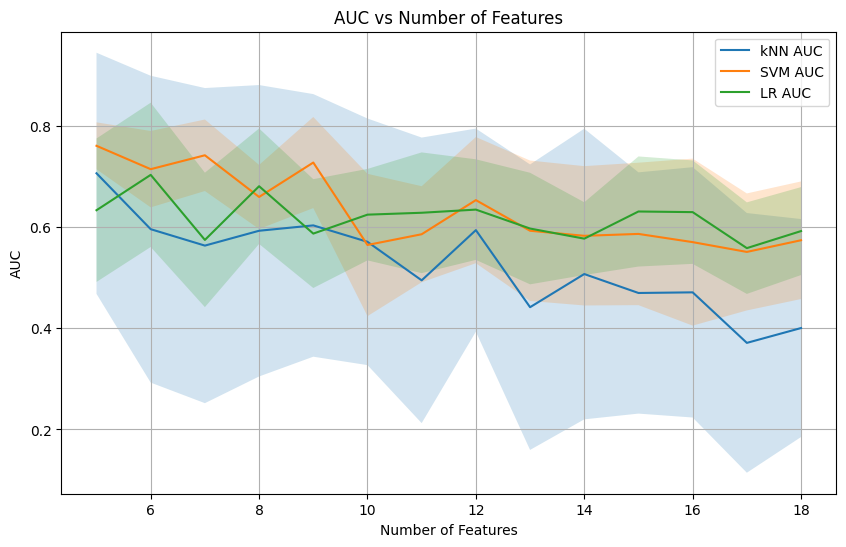

In [ ]:
import matplotlib.pyplot as plt

mean_auc_values = {}
std_auc_values = {}

# 绘制曲线图
plt.figure(figsize=(10, 6))

for model_name in plot_data.keys():
    n_features = plot_data[model_name]['n_features']
    mean_auc = plot_data[model_name]['mean_auc']
    std_auc = plot_data[model_name]['std_auc']

    print(len(n_features))
    print(len(mean_auc))
    print(len(std_auc))

    # 绘制曲线
    plt.plot(range(5, 19), mean_auc, label=f"{model_name} AUC")
    plt.fill_between(range(5, 19),
                     np.array(mean_auc) - np.array(std_auc),
                     np.array(mean_auc) + np.array(std_auc),
                     alpha=0.2)

plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('AUC vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize importance scores
def normalize_importances(importances):
    # Ensure non-negative by subtracting the minimum if it's negative
    importances -= importances.min() 
    # Normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(importances.reshape(-1, 1)).flatten()
    return normalized

# Initialize dictionary to store average importances for each model
average_importances = {model_name: {} for model_name in models}

# Aggregate importances across all folds
for fold_pfi in pfi_auc_all:
    for model_name, pfi_results in fold_pfi.items():
        importances_mean = pfi_results['importances_mean']
        feature_indices = model_results[model_name]['feature_list']  # Assuming this contains feature indices

        for idx, feature_importance in zip(feature_indices, importances_mean):
            if idx in average_importances[model_name]:
                average_importances[model_name][idx].append(feature_importance)
            else:
                average_importances[model_name][idx] = [feature_importance]

# Calculate average importances for each feature across all folds
for model_name in average_importances:
    for feature_idx in average_importances[model_name]:
        average_importances[model_name][feature_idx] = np.mean(average_importances[model_name][feature_idx])

# Normalize importances and create bar charts
for model_name, importances in average_importances.items():
    # Convert to sorted list of tuples (feature_idx, importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract top 10 features
    top_features = sorted_importances[:10]

    # Extract indices and their importance values
    feature_indices, importances = zip(*top_features)

    # Map indices to feature names
    feature_names = [featNames[idx] for idx in feature_indices]

    # Normalize the importances
    normalized_importances = normalize_importances(np.array(importances))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(normalized_importances)), normalized_importances, tick_label=feature_names)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xlabel('Feature Name')
    plt.ylabel('Normalized Importance Mean')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



ValueError: not enough values to unpack (expected 2, got 0)

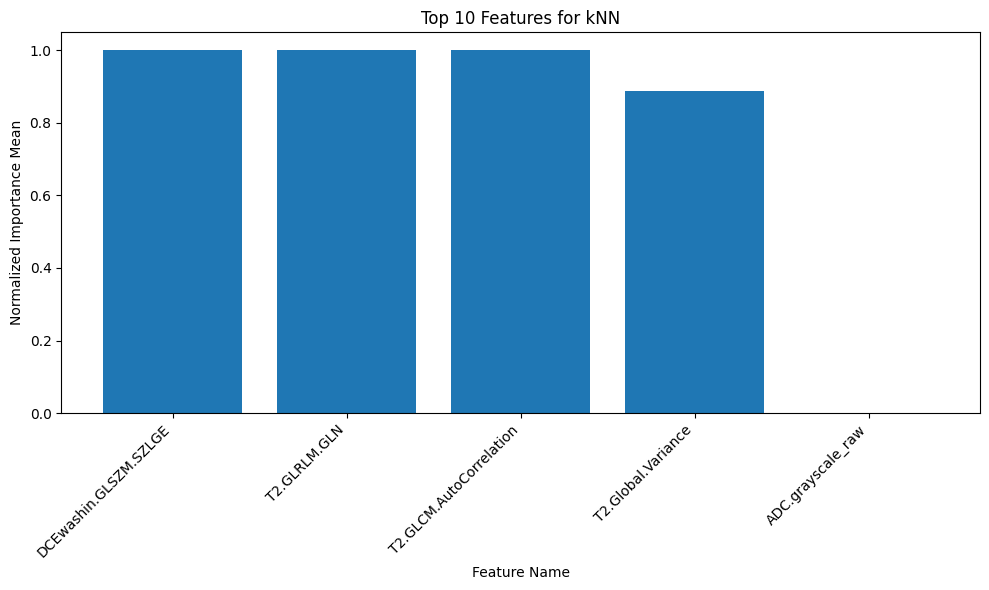

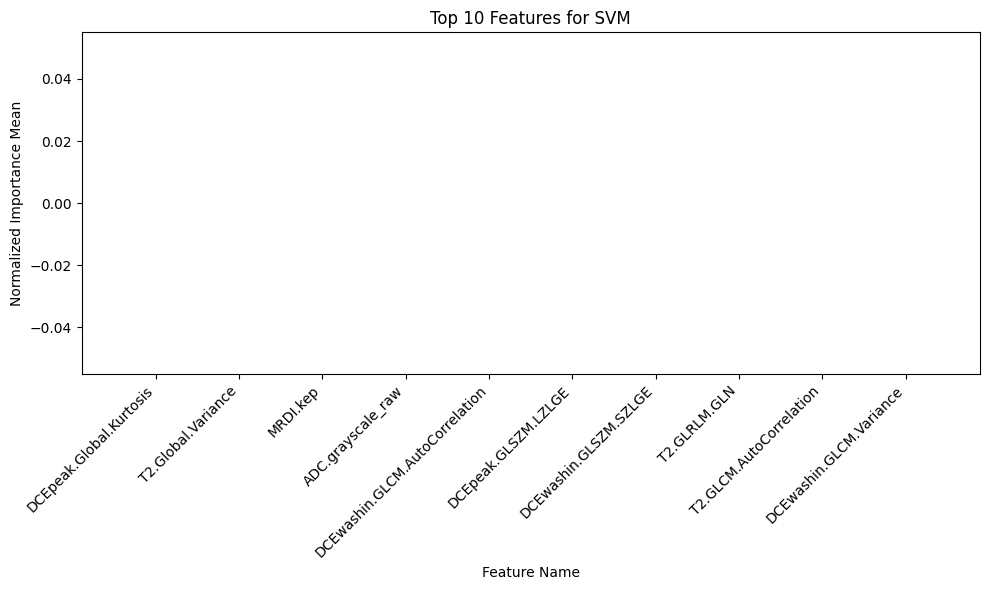

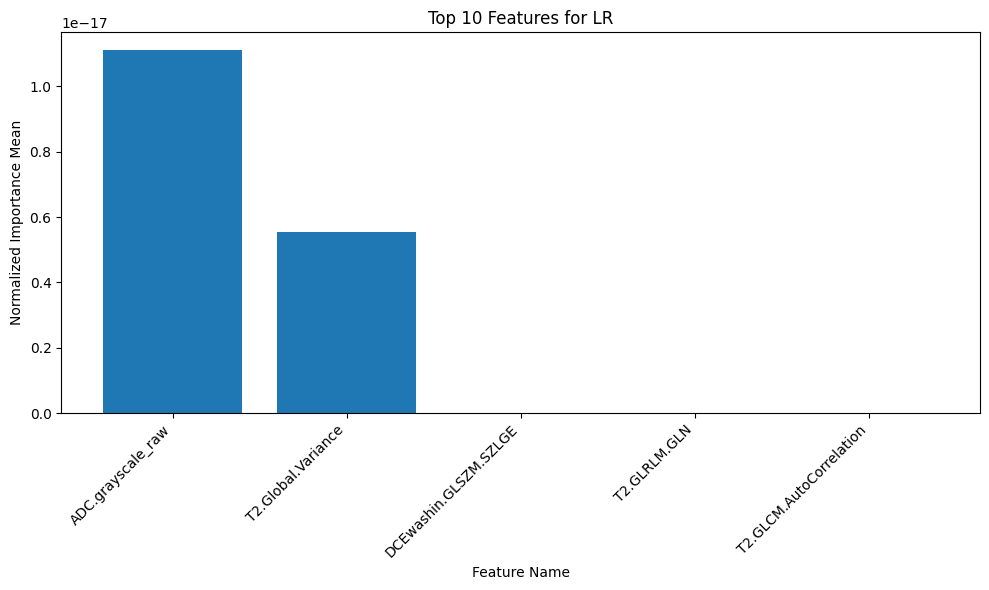

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize importance scores
def normalize_importances(importances):
    # Ensure non-negative by subtracting the minimum if it's negative
    importances -= importances.min() 
    # Normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(importances.reshape(-1, 1)).flatten()
    return normalized

# Initialize dictionary to store average importances for each model
average_importances = {model_name: {} for model_name in models}

# Aggregate importances across all folds
for fold_pfi in pfi_acc_all:
    for model_name, pfi_results in fold_pfi.items():
        importances_mean = pfi_results['importances_mean']
        feature_indices = model_results[model_name]['feature_list']  # Assuming this contains feature indices

        for idx, feature_importance in zip(feature_indices, importances_mean):
            if idx in average_importances[model_name]:
                average_importances[model_name][idx].append(feature_importance)
            else:
                average_importances[model_name][idx] = [feature_importance]

# Calculate average importances for each feature across all folds
for model_name in average_importances:
    for feature_idx in average_importances[model_name]:
        average_importances[model_name][feature_idx] = np.mean(average_importances[model_name][feature_idx])

# Normalize importances and create bar charts
for model_name, importances in average_importances.items():
    # Convert to sorted list of tuples (feature_idx, importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract top 10 features
    top_features = sorted_importances[:10]

    # Extract indices and their importance values
    feature_indices, importances = zip(*top_features)

    # Map indices to feature names
    feature_names = [featNames[idx] for idx in feature_indices]

    # Normalize the importances
    normalized_importances = normalize_importances(np.array(importances))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(normalized_importances)), normalized_importances, tick_label=feature_names)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xlabel('Feature Name')
    plt.ylabel('Normalized Importance Mean')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize importance scores
def normalize_importances(importances):
    # Ensure non-negative by subtracting the minimum if it's negative
    importances -= importances.min() 
    # Normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(importances.reshape(-1, 1)).flatten()
    return normalized

# Initialize dictionary to store average importances for each model
average_importances = {model_name: {} for model_name in models}

# Aggregate importances across all folds
for fold_pfi in pfi_bacc_all:
    for model_name, pfi_results in fold_pfi.items():
        importances_mean = pfi_results['importances_mean']
        feature_indices = model_results[model_name]['feature_list']  # Assuming this contains feature indices

        for idx, feature_importance in zip(feature_indices, importances_mean):
            if idx in average_importances[model_name]:
                average_importances[model_name][idx].append(feature_importance)
            else:
                average_importances[model_name][idx] = [feature_importance]

# Calculate average importances for each feature across all folds
for model_name in average_importances:
    for feature_idx in average_importances[model_name]:
        average_importances[model_name][feature_idx] = np.mean(average_importances[model_name][feature_idx])

# Normalize importances and create bar charts
for model_name, importances in average_importances.items():
    # Convert to sorted list of tuples (feature_idx, importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract top 10 features
    top_features = sorted_importances[:10]

    # Extract indices and their importance values
    feature_indices, importances = zip(*top_features)

    # Map indices to feature names
    feature_names = [featNames[idx] for idx in feature_indices]

    # Normalize the importances
    normalized_importances = normalize_importances(np.array(importances))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(normalized_importances)), normalized_importances, tick_label=feature_names)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xlabel('Feature Name')
    plt.ylabel('Normalized Importance Mean')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



ValueError: not enough values to unpack (expected 2, got 0)

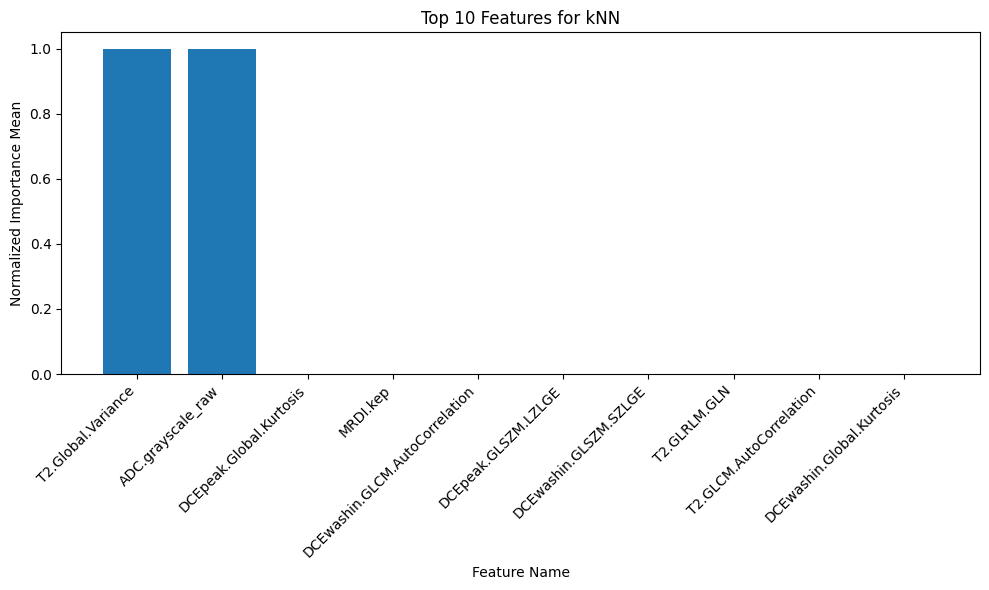

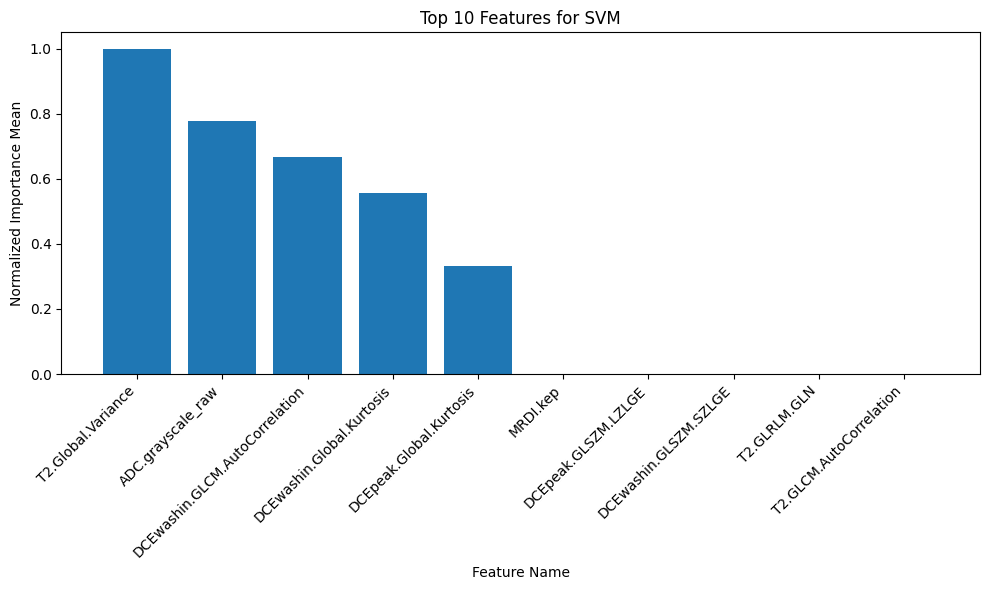

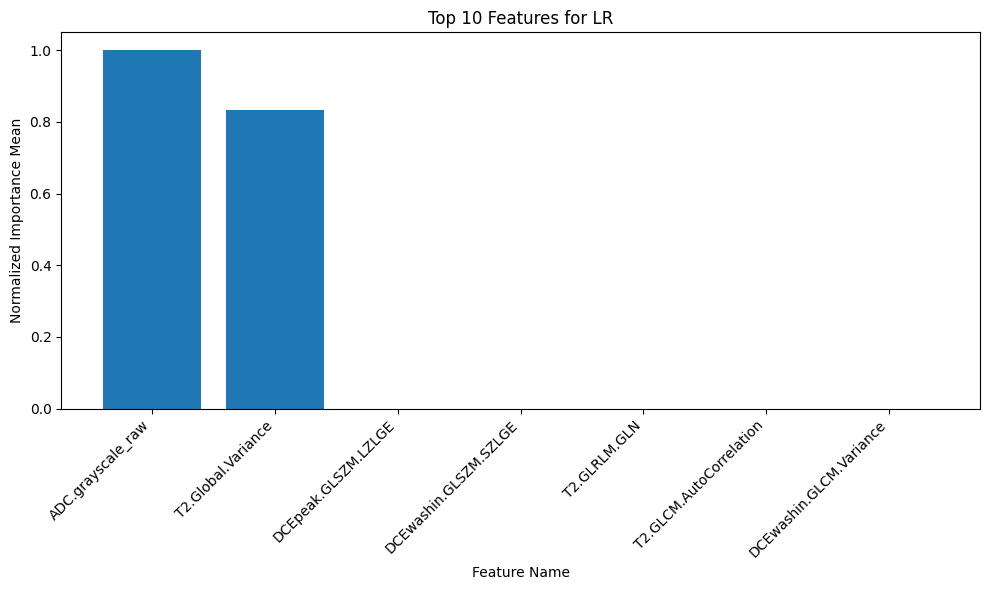

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize importance scores
def normalize_importances(importances):
    # Ensure non-negative by subtracting the minimum if it's negative
    importances -= importances.min() 
    # Normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(importances.reshape(-1, 1)).flatten()
    return normalized

# Initialize dictionary to store average importances for each model
average_importances = {model_name: {} for model_name in models}

# Aggregate importances across all folds
for fold_pfi in pfi_sens_all:
    for model_name, pfi_results in fold_pfi.items():
        importances_mean = pfi_results['importances_mean']
        feature_indices = model_results[model_name]['feature_list']  # Assuming this contains feature indices

        for idx, feature_importance in zip(feature_indices, importances_mean):
            if idx in average_importances[model_name]:
                average_importances[model_name][idx].append(feature_importance)
            else:
                average_importances[model_name][idx] = [feature_importance]

# Calculate average importances for each feature across all folds
for model_name in average_importances:
    for feature_idx in average_importances[model_name]:
        average_importances[model_name][feature_idx] = np.mean(average_importances[model_name][feature_idx])

# Normalize importances and create bar charts
for model_name, importances in average_importances.items():
    # Convert to sorted list of tuples (feature_idx, importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract top 10 features
    top_features = sorted_importances[:10]

    # Extract indices and their importance values
    feature_indices, importances = zip(*top_features)

    # Map indices to feature names
    feature_names = [featNames[idx] for idx in feature_indices]

    # Normalize the importances
    normalized_importances = normalize_importances(np.array(importances))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(normalized_importances)), normalized_importances, tick_label=feature_names)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xlabel('Feature Name')
    plt.ylabel('Normalized Importance Mean')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to normalize importance scores
def normalize_importances(importances):
    # Ensure non-negative by subtracting the minimum if it's negative
    importances -= importances.min() 
    # Normalize between 0 and 1
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(importances.reshape(-1, 1)).flatten()
    return normalized

# Initialize dictionary to store average importances for each model
average_importances = {model_name: {} for model_name in models}

# Aggregate importances across all folds
for fold_pfi in pfi_spec_all:
    for model_name, pfi_results in fold_pfi.items():
        importances_mean = pfi_results['importances_mean']
        feature_indices = model_results[model_name]['feature_list']  # Assuming this contains feature indices

        for idx, feature_importance in zip(feature_indices, importances_mean):
            if idx in average_importances[model_name]:
                average_importances[model_name][idx].append(feature_importance)
            else:
                average_importances[model_name][idx] = [feature_importance]

# Calculate average importances for each feature across all folds
for model_name in average_importances:
    for feature_idx in average_importances[model_name]:
        average_importances[model_name][feature_idx] = np.mean(average_importances[model_name][feature_idx])

# Normalize importances and create bar charts
for model_name, importances in average_importances.items():
    # Convert to sorted list of tuples (feature_idx, importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract top 10 features
    top_features = sorted_importances[:10]

    # Extract indices and their importance values
    feature_indices, importances = zip(*top_features)

    # Map indices to feature names
    feature_names = [featNames[idx] for idx in feature_indices]

    # Normalize the importances
    normalized_importances = normalize_importances(np.array(importances))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(normalized_importances)), normalized_importances, tick_label=feature_names)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xlabel('Feature Name')
    plt.ylabel('Normalized Importance Mean')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

